In [89]:
# load packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier

In [90]:
# import data
dateparser = lambda x: pd.to_datetime(x, format='%Y%m%d%H')
press = pd.read_csv('press.txt', delimiter=';', usecols=[1, 4], names=['dateTime', 'pressure'], 
                    skiprows=1, parse_dates=['dateTime'], date_parser=dateparser, index_col='dateTime')
temp = pd.read_csv('temp.txt', delimiter=';', usecols=[1, 4, 5], names=['dateTime', 'temperature', 'relative_humidity'], 
                    skiprows=1, parse_dates=['dateTime'], date_parser=dateparser, index_col='dateTime')
rain = pd.read_csv('rain.txt', delimiter=';', usecols=[1, 4], names=['dateTime', 'rain'], 
                    skiprows=1, parse_dates=['dateTime'], date_parser=dateparser, index_col='dateTime')

In [91]:
# re-organize data
df = rain
df['atmpress'] = press['pressure']
df['airtemp'] = temp['temperature']
df['relhum'] = temp['relative_humidity']

# add column with rainfall as binary variable (0=dry, 1=rain)
df['rainbinary'] = np.asarray([1 if p>0 else 0 for p in df['rain']])

# remove missing data (labeled in this data source as -999)
df = df[df != -999]
df = df.dropna(how='any')

# check resulting DataFrame
df.head()

rain  atmpress  airtemp  relhum  rainbinary
dateTime                                                        
2015-08-20 01:00:00   0.0    1022.4     15.9    92.0           0
2015-08-20 02:00:00   0.0    1022.6     15.2    93.0           0
2015-08-20 03:00:00   0.0    1022.9     14.8    87.0           0
2015-08-20 04:00:00   0.0    1023.2     14.6    70.0           0
2015-08-20 05:00:00   0.0    1023.7     15.0    63.0           0

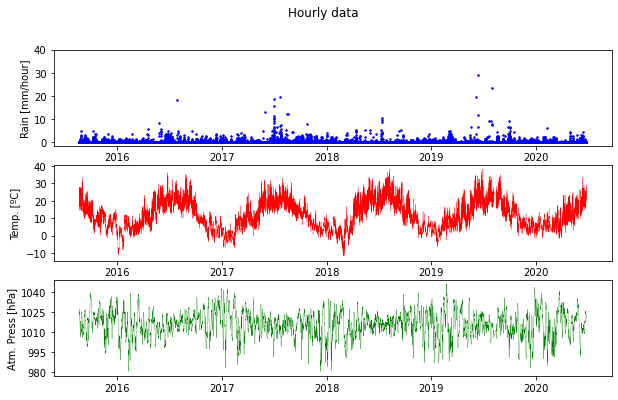

In [92]:
# plot time series
plt.figure(figsize=[10, 6])
plt.subplot(311)
plt.plot(df['rain'], 'b.', markersize=3)
plt.ylabel('Rain [mm/hour]')
plt.yticks(np.linspace(0, 40, 5))
plt.subplot(312)
plt.plot(df['airtemp'], '-r', linewidth=0.3)
plt.yticks(np.linspace(-10, 40, 6))
plt.ylabel('Temp. [ºC]')
plt.subplot(313)
plt.plot(df['atmpress'], '-g', linewidth=0.3)
plt.ylabel('Atm. Press [hPa]')
plt.yticks(np.linspace(980, 1040, 5))
plt.suptitle('Hourly data')
plt.show()

In [93]:
# aggregate data to daily scale
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
dfdaily = df.groupby(['year', 'month', 'day'])
dfdaily = dfdaily[['atmpress', 'relhum', 'rainbinary']]
dfdaily = dfdaily.agg({'atmpress':'mean', 'relhum': 'mean', 'rainbinary': 'max'})
dfdaily.head()

# check resulting DataFrame
dfdaily.head()

atmpress     relhum  rainbinary
year month day                                    
2015 8     20   1024.095000  46.000000           0
           21   1025.442857  37.761905           0
           22   1022.104545  35.863636           0
           23   1014.662500  43.791667           0
           24   1007.637500  62.208333           1

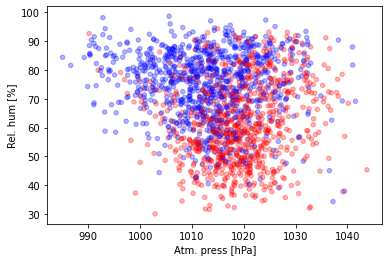

In [94]:
# plot classification based on atm. pressure and rel. humidity
plt.figure()
plt.scatter('atmpress', 'relhum', alpha=0.3, s=20, c=['r' if i==0 else 'b' for i in dfdaily['rainbinary']], data=dfdaily)
plt.xlabel('Atm. press [hPa]')
plt.ylabel('Rel. hum [%]')
plt.show()

In [95]:
# prepare input data for models
X = np.asarray(dfdaily[['atmpress', 'relhum']])
y = np.asarray(dfdaily['rainbinary'])

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

# train models (linear perceptron, k-nearest-neighbors)
mod_perc = Perceptron()
mod_knn = KNeighborsClassifier(n_neighbors=10)

mod_perc.fit(X_train, y_train)
mod_knn.fit(X_train, y_train)

# predict
y_pred_perc = mod_perc.predict(X_test)
y_pred_knn = mod_knn.predict(X_test)

In [96]:
# function to compute prediction quality
def predQual(y_test, y_pred):
    """compute number of true positives (tp), false positives (fp),
     true negatives (tn) and false negatives (fn)"""
    tp, fp, tn, fn = [0, 0, 0, 0]
    for obs, pred in zip(y_test, y_pred):
        if (obs == 1) & (pred == 1):
            tp += 1
        elif (obs == 0) & (pred == 0):
            tn += 1
        elif (obs == 1) & (pred == 0):
            fn += 1
        else:
            fp += 1
    return([tp, fp, tn, fn])


# compute prediction quality
tp_perc, fp_perc, tn_perc, fn_perc = predQual(y_test, y_pred_perc)
tp_knn, fp_knn, tn_knn, fn_knn = predQual(y_test, y_pred_knn)

In [97]:
# print out quality indicators
print('Linear perceptron:')
print(f'Precision = {tp_perc/(tp_perc + fp_perc):.3f}')
print(f'Recall (=Sensitiviy) = {tp_perc/(tp_perc + fn_perc):.3f}')
print('\nk-nearest-neighbors:')
print(f'Precision = {tp_knn/(tp_knn + fp_knn):.3f}')
print(f'Recall (=Sensitiviy) = {tp_knn/(tp_knn + fn_knn):.3f}')


Linear perceptron:
Precision = 0.617
Recall (=Sensitiviy) = 0.915

k-nearest-neighbors:
Precision = 0.777
Recall (=Sensitiviy) = 0.693
